In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pickle

In [21]:
print('kernel alive')

kernel alive
0.08


In [12]:
path = 'G:\\Data\\Qudi_Data\\2024\\01\\20240101\\AttoDRY2200_Pi3_SPM\\'
filebeginning = '20240101-1816-01_scan80_laser_0.06V_165mT_Bnv_FC_slow_large_6.1K_autosave_NbSe2_S2_A-T17-12_' #here the beginning of the filename, including the date and sample name, is needed
filepath = path + filebeginning

## Load data from pickel

In [13]:
with open(filepath+'qafm_array_raw.pickle', 'rb') as f:
    qafm_data = pickle.load(f)
with open(filepath+'pulsed_array_raw.pickle', 'rb') as f:
    pulsed_data = pickle.load(f)

## Load data from data arrays

In [48]:
#qafm_data = afm_scanner_logic._qafm_scan_array
#pulsed_data = afm_scanner_logic._pulsed_scan_array

## Calculate bias field - OOC

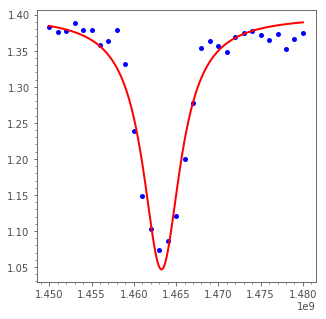

Bias field: 0.1551169686529164 T
FWHM: 5.358202346511284 MHz


In [14]:
#Analyse bias field
#Gathering data from dictonary
directory = 'G:\\Data\\Qudi_Data\\2023\\12\\20231230\\PODMR\\'
podrm_path = directory + '20231230-2018-31_sc79_laser_0.06V_165mT_Bnv_FC_slow_OOC_large_4.7K_ODMR_data_ch0_range0'+'.dat'
data_raw = np.loadtxt(podrm_path).T
var_list,data = (data_raw[0],data_raw[1])

gyro_nv = 28e9 #in Hz/T
e_field = 0 #in Hz
zero_field = 2.88e9 #in Hz, watch the Temperature

mode = ''
gslac = True
left = True

#Determine fit

if mode == 'double':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
elif mode == 'N15':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
elif mode == 'N14':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N14)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
else:    
    fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
    lm,_ = fitlogic.make_lorentzian_model()

# print(fit.fit_report())
bias_res_freq = fit.params['center'].value

if gslac == True and left == True:
    b_field_bias = np.sqrt(abs(bias_res_freq + zero_field)**2 - e_field**2) / gyro_nv
else:
    b_field_bias = np.sqrt(abs(bias_res_freq - zero_field)**2 - e_field**2) / gyro_nv

#Plot Data an
plt.plot(var_list,data,'bo')

x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
plt.plot(x, lm.eval(fit.params, x=x),'r-')

plt.show()
print('Bias field:',b_field_bias,'T')
print('FWHM:',fit.params['fwhm'].value*1e-6,'MHz')

## Calculate B field from tracked res. freq. - 2D array

In [15]:
res_freq = qafm_data['fit_param_fw']['data']

gyro_nv = 28e9 #in Hz/T
e_field = 0 #in Hz
zero_field = 2.88e9 #in Hz, watch the Temperature

gslac = True
left = True

if gslac == True and left == True:
    b_field = np.sqrt(abs(res_freq + zero_field)**2 - e_field**2) / gyro_nv
else:
    b_field = np.sqrt(abs(res_freq - zero_field)**2 - e_field**2) / gyro_nv

## Plot B field uncorrected - Bnv

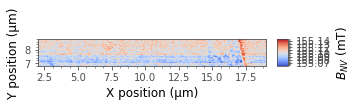

In [16]:
#Plot analysed Data from PODMR
x = (qafm_data['Height(Dac)_fw']['coord0_arr'])*10**6
y = (qafm_data['Height(Dac)_fw']['coord1_arr'])*10**6

plt.rcParams['figure.figsize'] = (5, 5)
fontsize = 12

low_centile = 0
high_centile = 100
data = (b_field)*10**3
im = plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)',fontsize = fontsize)
plt.ylabel('Y position (\u03BCm)',fontsize = fontsize)

ax = plt.gca()
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='$B_{NV}$ (mT)', size=fontsize)

plt.tight_layout()

plt.show()

## Plot corrected B field - Bnv - Bbias

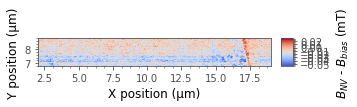

In [17]:
#Plot analysed Data from PODMR
x = (qafm_data['Height(Dac)_fw']['coord0_arr'])*10**6
y = (qafm_data['Height(Dac)_fw']['coord1_arr'])*10**6

#plt.rcParams['figure.figsize'] = (5, 5)
fontsize = 12

low_centile = 0
high_centile = 100
data = (b_field-b_field_bias)*10**3
im = plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)',fontsize = fontsize)
plt.ylabel('Y position (\u03BCm)',fontsize = fontsize)

ax = plt.gca()
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='$B_{NV}$ - $B_{bias}$ (mT)', size=fontsize)

plt.tight_layout()

plt.show()

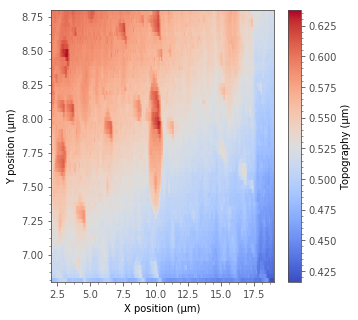

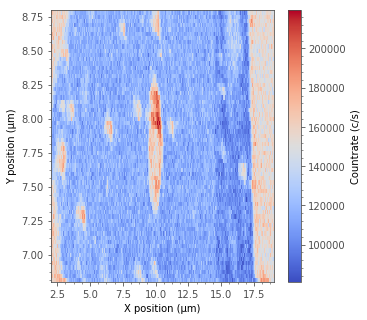

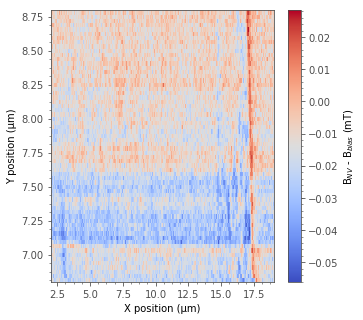

In [18]:
#Plot analysed Data from PODMR
x_gwy = qafm_data['Height(Dac)_fw']['coord0_arr']
y_gwy = qafm_data['Height(Dac)_fw']['coord1_arr']
x = x_gwy*10**6
y = y_gwy*10**6

#for gwyddion
dataobj = {}

## TOPO ##

low_centile = 0
high_centile = 100
data = qafm_data['Height(Dac)_fw']['data']*10**6
plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'Topography (\u03BCm)')
plt.show()
#for gwyddion
dataobj['Topography'] = {
                            'coord0_arr':x_gwy,
                            'coord1_arr':y_gwy,
                            'data':qafm_data['Height(Dac)_fw']['data'],
                            'params': {'coord0_start': x_gwy[0],'coord0_stop': x_gwy[-1],'coord1_start': y_gwy[0],'coord1_stop': y_gwy[-1]},
                            'xy_units': 'm',                                                
                            'si_units': 'm',
                            'nice_name': 'Topography'
    
                        }
## COUNTS ##

low_centile = 0
high_centile = 100
data = qafm_data['counts_fw']['data']
plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'Countrate (c/s)')
plt.show()
#for gwyddion
dataobj['Fluorescence'] = {
                            'coord0_arr':x_gwy,
                            'coord1_arr':y_gwy,
                            'data':qafm_data['counts_fw']['data'],
                            'params': {'coord0_start': x_gwy[0],'coord0_stop': x_gwy[-1],'coord1_start': y_gwy[0],'coord1_stop': y_gwy[-1]},
                            'xy_units': 'm',                                                
                            'si_units': 'c/s',
                            'nice_name': 'Fluorescence'
    
                        }
## RES FREQ ##

# low_centile = 0.75
# high_centile = 99.8
# data = res_freq/10**9
# plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
# plt.xlabel('X position (\u03BCm)')
# plt.ylabel('Y position (\u03BCm)')
# plt.colorbar(label = 'Frequency (GHz)')
# plt.show()


## BFIELD CORR mT ##

low_centile = 0
high_centile = 100
data = b_field*10**3 -b_field_bias*10**3 # b_field_bias is found earlier from OOC fit. In tesla
plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'B$_{NV}$ - B$_{bias}$ (mT)')
plt.show()
#for gwyddion
dataobj['Stray Field'] = {
                            'coord0_arr':x_gwy,
                            'coord1_arr':y_gwy,
                            'data':b_field-b_field_bias,
                            'params': {'coord0_start': x_gwy[0],'coord0_stop': x_gwy[-1],'coord1_start': y_gwy[0],'coord1_stop': y_gwy[-1]},
                            'xy_units': 'm',                        
                            'si_units': 'T',
                            'nice_name': 'Stray Field: B_NV - B_bias'
    
                        }


## 5.a.i. Save data to Gwyddion function

In [9]:
def save_obj_to_gwyddion(dataobj,filename,gwytypes=['image']):
    """save_obj_to_gwyddion(): writes qudi data object to Gwyddion file
        input:  
        - dataobj: proteusQ data object of from dataobj['data_key']
        - filename: file path to save object
        - prefix:  name to be prefixed to all head objects

        requirements:
        dataobj['scan_type'] must contain keys {coord0[], coord1[], data[,], params[coord0-1_start-stop], si_units, nice_name}
    """

    # check for existance of valid object names
    datakeys = list(dataobj.keys())

    # overall object container
    objout = gwy.objects.GwyContainer()

    for dataki,datak in enumerate(sorted(datakeys, key=str.lower)):
        meas = dataobj[datak]

        # check that data is valid
        if not {'coord0_arr','coord1_arr','data'}.issubset(set(meas.keys())):
            continue 

        # check that there is non-trivial data (skip empty measurements)
        if np.sum(meas['data']) == 0.0:
            continue

        # transform data
        #scalefactor = meas['scale_fac']
        coord0 = meas['coord0_arr']
        coord1 = meas['coord1_arr']
        data_si = meas['data'] #* scalefactor

        params = meas['params']
        coord0_start = next(k for k in params.keys() if k.startswith('coord0_start'))
        coord0_stop = next(k for k in params.keys() if k.startswith('coord0_stop'))
        coord1_start = next(k for k in params.keys() if k.startswith('coord1_start'))
        coord1_stop = next(k for k in params.keys() if k.startswith('coord1_stop'))

        xy_units = meas['xy_units']
        z_units = meas['si_units']
        measname = datak + ":" + meas['nice_name']

        # encode to image
        img = gwy.objects.GwyDataField(data=data_si, si_unit_xy=xy_units, si_unit_z=z_units)
        img.xoff = params[coord0_start]
        img.xreal = params[coord0_stop] - params[coord0_start]
        img.yoff = params[coord1_start]
        img.yreal = params[coord1_stop] - params[coord1_start]

        # add to parent object 
        if 'image' in gwytypes: 
            # image types
            basekey = '/' + str(dataki) + '/data'
            objout[basekey + '/title'] = measname
            objout['/' + str(dataki) + '/base/palette'] = 'Sky'
            objout[basekey] = img
            # comment meta data
            if meas['params']:
                d = {key: str(val) for key, val in meas['params'].items()}
                meta = gwy.objects.GwyContainer(d)
                objout['/' + str(dataki) + '/meta'] = meta

    # write out file    
    if objout:
        objout.tofile(filename)

## 5.a Save to new gwyddion file - data defined in previous cell

In [19]:
"""save_obj_to_gwyddion(): writes qudi data object to Gwyddion file
        input:  
        - dataobj: proteusQ data object of from dataobj['data_key']
        - filename: file path to save object
        - prefix:  name to be prefixed to all head objects

        requirements:
        dataobj['scan_type'] must contain keys {coord0[], coord1[], data[,], params[coord0-1_start-stop], si_units, nice_name}
    """
from logic import gwyfile as gwy
save_obj_to_gwyddion(dataobj=dataobj,filename=filepath+'QAFM_jupyter_corrected.gwy')

### Filtering the B field data with gaussian filter (non square pixels)

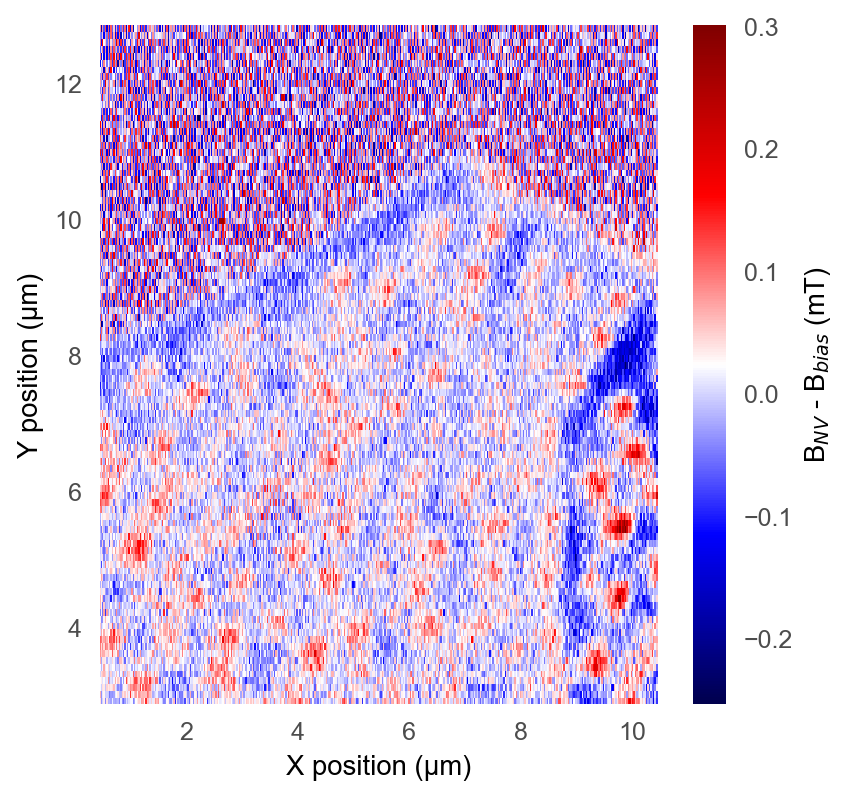

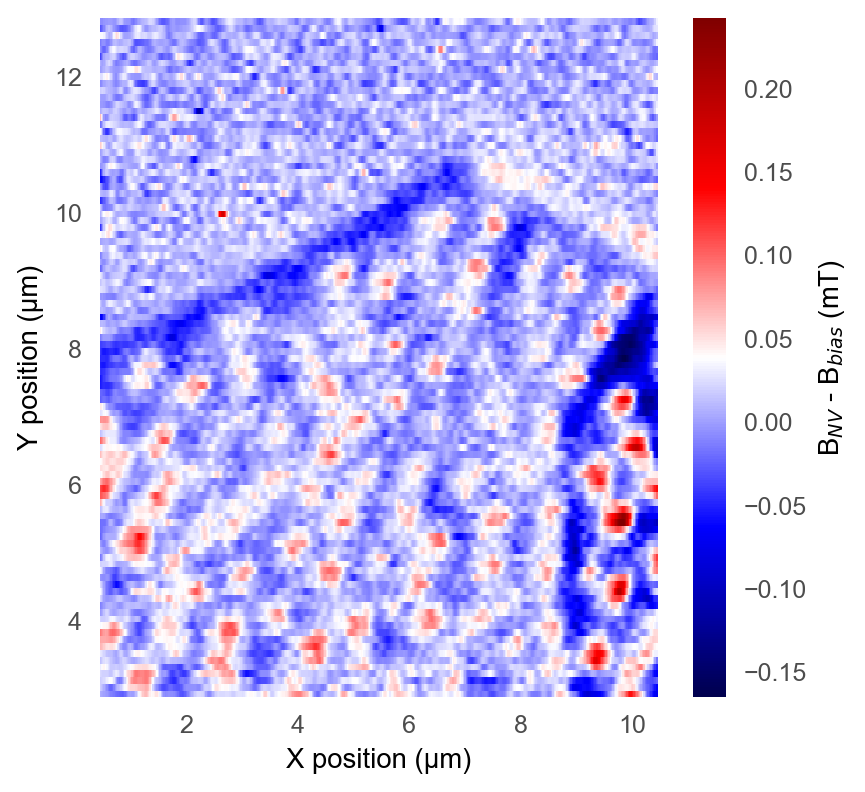

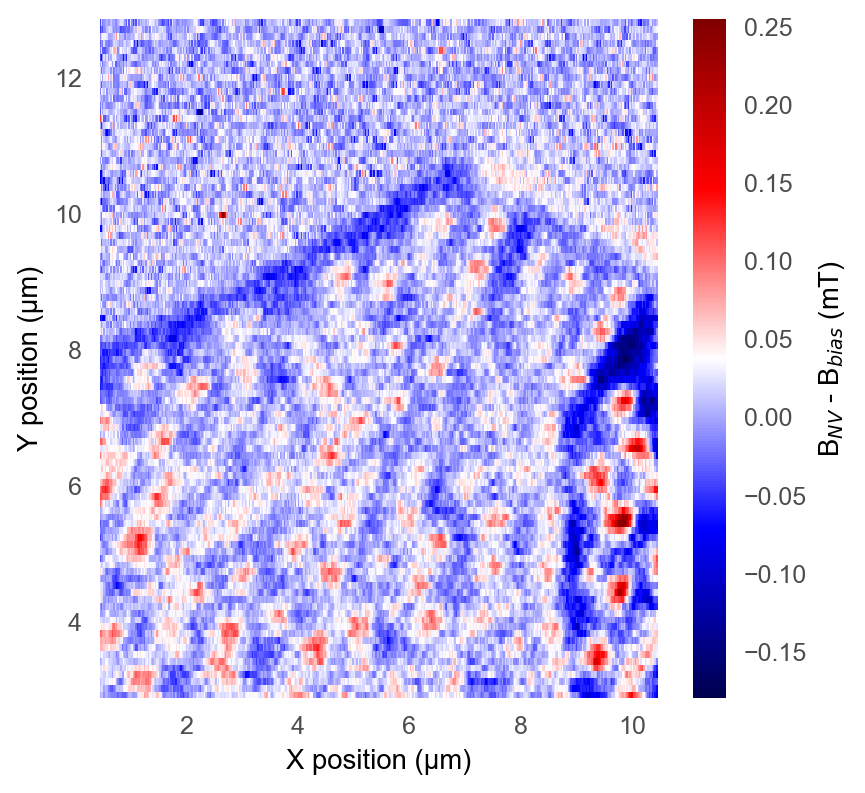

In [181]:
from scipy.ndimage import gaussian_filter as gf

data = (b_field -b_field_bias).copy()
data_filt = (b_field -b_field_bias).copy()

low_centile = 0
high_centile = 100

# b_field_bias is found earlier from OOC fit. In tesla
data_plt = (data*10**3).copy()
plt.pcolormesh(x,y,data_plt,cmap=plt.cm.get_cmap('seismic'), vmin =np.nanpercentile(data_plt, low_centile), vmax = np.nanpercentile(data_plt, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'B$_{NV}$ - B$_{bias}$ (mT)')
plt.show()

for i,data_row in enumerate(data_filt):
    data_row = scipy.ndimage.gaussian_filter1d(data_row, sigma=2)
    data_filt[i] = data_row

# b_field_bias is found earlier from OOC fit. In tesla
data_plt = (data_filt*10**3).copy()
plt.pcolormesh(x,y,data_plt,cmap=plt.cm.get_cmap('seismic'), vmin =np.nanpercentile(data_plt, low_centile), vmax = np.nanpercentile(data_plt, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'B$_{NV}$ - B$_{bias}$ (mT)')
plt.show()

dataobj['Stray Field (Gaussian_Filt)'] = {
                            'coord0_arr':x_gwy,
                            'coord1_arr':y_gwy,
                            'data':data_filt,
                            'params': {'coord0_start': x_gwy[0],'coord0_stop': x_gwy[-1],'coord1_start': y_gwy[0],'coord1_stop': y_gwy[-1]},
                            'xy_units': 'm',                        
                            'si_units': 'T',
                            'nice_name': 'Stray Field (Gaussian Filtered): B_NV - B_bias'
    
                        }

data_filt = (b_field -b_field_bias).copy()
for i,data_row in enumerate(data_filt):
    data_row = scipy.ndimage.uniform_filter1d(data_row, size=4)
    data_filt[i] = data_row

# b_field_bias is found earlier from OOC fit. In tesla
data_plt = (data_filt*10**3).copy()
plt.pcolormesh(x,y,data_plt,cmap=plt.cm.get_cmap('seismic'), vmin =np.nanpercentile(data_plt, low_centile), vmax = np.nanpercentile(data_plt, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'B$_{NV}$ - B$_{bias}$ (mT)')
plt.show()

dataobj['Stray Field (Mean_Filt)'] = {
                            'coord0_arr':x_gwy,
                            'coord1_arr':y_gwy,
                            'data':data_filt,
                            'params': {'coord0_start': x_gwy[0],'coord0_stop': x_gwy[-1],'coord1_start': y_gwy[0],'coord1_stop': y_gwy[-1]},
                            'xy_units': 'm',                        
                            'si_units': 'T',
                            'nice_name': 'Stray Field (Mean Filtered): B_NV - B_bias'
    
                        }

## Saved images in multiple formats - matplotlib style

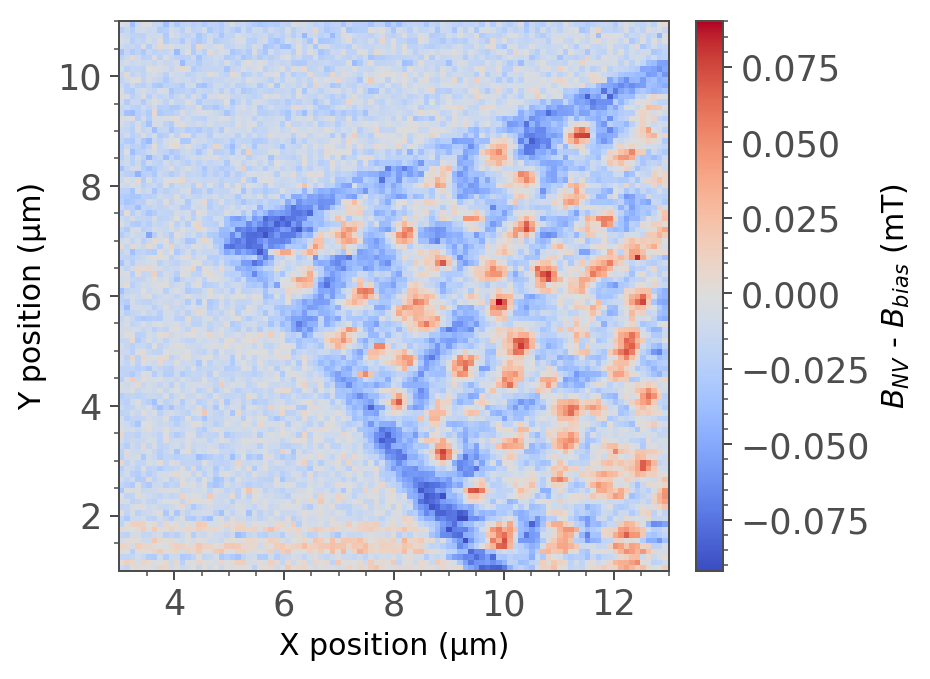

In [47]:
#Save b field image in Gauss
x = (qafm_data['Height(Dac)_fw']['coord0_arr'])*10**6
y = (qafm_data['Height(Dac)_fw']['coord1_arr'])*10**6

plt.rcParams['figure.figsize'] = (5, 4)
fontsize = 12

low_centile = 0
high_centile = 100
data = (b_field-b_field_bias)*10**3
im = plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)',fontsize = fontsize)
plt.ylabel('Y position (\u03BCm)',fontsize = fontsize)

ax = plt.gca()
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(im, cax=cax, use_gridspec=True)
cbar.set_label(label='$B_{NV}$ - $B_{bias}$ (mT)', size=fontsize)

plt.tight_layout()

with open(filepath+'QAFM_b_field_fw_fig_corrected.png', 'wb') as f:
    plt.savefig(f,format='png')
with open(filepath+'QAFM_b_field_fw_fig_corrected.pdf', 'wb') as f:
    plt.savefig(f,format='pdf')
with open(filepath+'QAFM_b_field_fw_fig_corrected.svg', 'wb') as f:
    plt.savefig(f,format='svg')

plt.show()

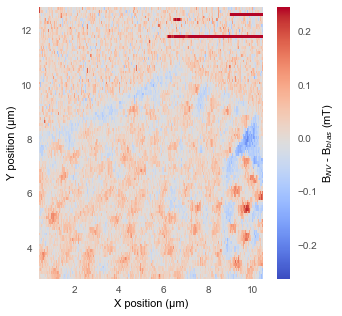

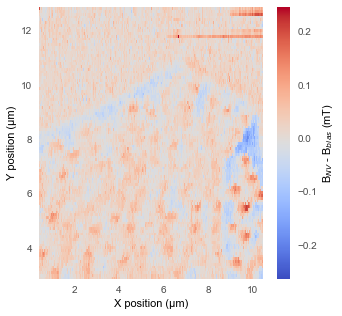

Traceback (most recent call last):
  File "C:\Users\yy3\Documents\Software\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-94-e9fec2b6e866>", line 36, in <module>
    filt2 = cv2.bilateralFilter(data_filt, 2,2,2)    # default sigma: computed by OpenCV
cv2.error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgproc\src\smooth.cpp:5999: error: (-210:Unsupported format or combination of formats) Bilateral filtering is only implemented for 8u and 32f images in function 'cv::bilateralFilter'



In [94]:
import cv2

data_filt = (b_field*10**3 -b_field_bias*10**3).copy()

filt2 = kuwahara(data_filt, method='gaussian', sigma=1, radius=2)    # default sigma: computed by OpenCV

# b_field_bias is found earlier from OOC fit. In tesla
plt.pcolormesh(x,y,filt2,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'B$_{NV}$ - B$_{bias}$ (mT)')
plt.show()


dataobj['Stray Field (Kuwahara)'] = {
                            'coord0_arr':x_gwy,
                            'coord1_arr':y_gwy,
                            'data':filt2,
                            'params': {'coord0_start': x_gwy[0],'coord0_stop': x_gwy[-1],'coord1_start': y_gwy[0],'coord1_stop': y_gwy[-1]},
                            'xy_units': 'm',                        
                            'si_units': 'T',
                            'nice_name': 'Stray Field (Kuwahara): B_NV - B_bias'
    
                        }

filt2 = kuwahara01(data_filt, method='gaussian', sigma=1, radius=2)    # default sigma: computed by OpenCV

# b_field_bias is found earlier from OOC fit. In tesla
plt.pcolormesh(x,y,filt2,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'B$_{NV}$ - B$_{bias}$ (mT)')
plt.show()


filt2 = cv2.bilateralFilter(data_filt, 2,2,2)    # default sigma: computed by OpenCV
from skimage import data, img_as_float
astro = img_as_float(data.astronaut())
astro = astro[220:300, 220:320]
rng = np.random.default_rng()
noisy = astro + 0.6 * astro.std() * rng.random(astro.shape)
noisy = np.clip(noisy, 0, 1)
denoised = denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15,
                             channel_axis=-1)


# b_field_bias is found earlier from OOC fit. In tesla
plt.pcolormesh(x,y,filt2,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'B$_{NV}$ - B$_{bias}$ (mT)')
plt.show()


In [91]:
def kuwahara(orig_img, method='mean', radius=3, sigma=None, grayconv=cv2.COLOR_BGR2GRAY, image_2d=None):
    """
    Get the image filtered with Kuwahara method.

    :param orig_img: original numpy image (support multichannel)
    :type orig_img: :class:`numpy.ndarray`
    :param method: method used to compute the pixels values
    :type method: "gaussian" | "mean"
    :param radius: the window radius (`winsize = 2 * radius + 1`)
    :type radius: `int`
    :param sigma: the sigma used if metod is "gaussian", automatically computed by OpenCV when `None`
    :type sigma: `float` or `None`
    :param grayconv: The OpenCV conversion code to extract grayscale image from `orig_img` (default `COLOR_BGR2GRAY`)
    :type grayconv: `int`
    :param image_2d: The 1-channel image used to compute the variance, if provided instead of `grayconv`
    :type image_2d: `numpy.ndarray`
    :returns: the filtered image
    :rtype: `numpy.ndarray`
    """

    # Filter description:
    # The Kuwahara filter works on a window divided into 4 overlapping
    # subwindows (for a 5x5 pixels example, see below). In each subwindow, the mean and
    # variance are computed. The output value (located at the center of the
    # window) is set to the mean of the subwindow with the smallest variance.
    #
    #     ( a  a  ab   b  b)
    #     ( a  a  ab   b  b)
    #     (ac ac abcd bd bd)
    #     ( c  c  cd   d  d)
    #     ( c  c  cd   d  d)
    #
    # Inspired by:
    #       python-kuwahara by Andrew Dussault, 2015 : https://github.com/adussault/python-kuwahara
    #       which it itself based on original Matlab code from Luca Balbi, 2007

    if orig_img.ndim != 2 and orig_img.ndim != 3:
        raise TypeError("Incorrect number of dimensions (excepted 2 or 3)")

    if not isinstance(radius, int):
        raise TypeError('`radius` must be int')

    if radius < 1:
        raise ValueError('`radius` must be greater or equal 1')

    if method not in ('mean', 'gaussian'):
        raise NotImplementedError('unsupported method %s' % method)

    if method == 'gaussian' and sigma is None:
        sigma = -1
        # then computed by OpenCV as : 0.3 * ((ksize - 1) * 0.5 - 1) + 0.8
        # see: https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#gac05a120c1ae92a6060dd0db190a61afa

    # convert to float32 if necessary for further math computation
    image = orig_img.astype(np.float32, copy=False)

    if image_2d is not None:
        image_2d = image_2d.astype(image.dtype, copy=False)

    # preallocate these arrays
    avgs = np.empty((4, *image.shape), dtype=image.dtype)
    stddevs = np.empty((4, *image.shape[:2]), dtype=image.dtype)

    if image.ndim == 3:
        if image_2d is None:
            # NOTE this doesn't support float64
            image_2d = cv2.cvtColor(orig_img, grayconv).astype(image.dtype, copy=False)
        avgs_2d = np.empty((4, *image.shape[:2]), dtype=image.dtype)
    elif image.ndim == 2:
        image_2d = image
        avgs_2d = avgs

    # Create a pixel-by-pixel square of the image
    squared_img = image_2d ** 2

    if method == 'mean':
        kxy = np.ones(radius + 1, dtype=image.dtype) / (radius + 1)    # kernelX and kernelY (same)
    elif method == 'gaussian':
        kxy = cv2.getGaussianKernel(2 * radius + 1, sigma, ktype=cv2.CV_32F)
        kxy /= kxy[radius:].sum()   # normalize the semi-kernels
        klr = np.array([kxy[:radius+1], kxy[radius:]])
        kindexes = [[1, 1], [1, 0], [0, 1], [0, 0]]

    # the pixel position for all kernel quadrants
    shift = [(0, 0), (0,  radius), (radius, 0), (radius, radius)]

    # Calculation of averages and variances on subwindows
    for k in range(4):
        if method == 'mean':
            kx = ky = kxy
        elif method == 'gaussian':
            kx, ky = klr[kindexes[k]]
        cv2.sepFilter2D(image, -1, kx, ky, avgs[k], shift[k])
        if image.ndim == 3: # else, this is already done...
            cv2.sepFilter2D(image_2d, -1, kx, ky, avgs_2d[k], shift[k])
        cv2.sepFilter2D(squared_img, -1, kx, ky, stddevs[k], shift[k])
        stddevs[k] = stddevs[k] - avgs_2d[k] ** 2    # compute the final variance on subwindow

    # Choice of index with minimum variance
    indices = np.argmin(stddevs, axis=0)

    # Building the filtered image
    if image.ndim == 2:
        filtered = np.take_along_axis(avgs, indices[None,...], 0).reshape(image.shape)
    else:   # then avgs.ndim == 4
        filtered = np.take_along_axis(avgs, indices[None,...,None], 0).reshape(image.shape)

    return filtered.astype(orig_img.dtype)
def kuwahara01(orig_img, method='mean', radius=3, sigma=None, grayconv=cv2.COLOR_BGR2GRAY, image_2d=None):
    """
    Get the image filtered with Kuwahara method.

    :param orig_img: original numpy image (support multichannel)
    :type orig_img: :class:`numpy.ndarray`
    :param method: method used to compute the pixels values
    :type method: "gaussian" | "mean"
    :param radius: the window radius (`winsize = 2 * radius + 1`)
    :type radius: `int`
    :param sigma: the sigma used if metod is "gaussian", automatically computed by OpenCV when `None`
    :type sigma: `float` or `None`
    :param grayconv: The OpenCV conversion code to extract grayscale image from `orig_img` (default `COLOR_BGR2GRAY`)
    :type grayconv: `int`
    :param image_2d: The 1-channel image used to compute the variance, if provided instead of `grayconv`
    :type image_2d: `numpy.ndarray`
    :returns: the filtered image
    :rtype: `numpy.ndarray`
    """

    # Filter description:
    # The Kuwahara filter works on a window divided into 4 overlapping
    # subwindows (for a 5x5 pixels example, see below). In each subwindow, the mean and
    # variance are computed. The output value (located at the center of the
    # window) is set to the mean of the subwindow with the smallest variance.
    #
    #     ( a  a  ab   b  b)
    #     ( a  a  ab   b  b)
    #     (ac ac abcd bd bd)
    #     ( c  c  cd   d  d)
    #     ( c  c  cd   d  d)
    #
    # Inspired by:
    #       python-kuwahara by Andrew Dussault, 2015 : https://github.com/adussault/python-kuwahara
    #       which it itself based on original Matlab code from Luca Balbi, 2007

    if orig_img.ndim != 2 and orig_img.ndim != 3:
        raise TypeError("Incorrect number of dimensions (excepted 2 or 3)")

    if not isinstance(radius, int):
        raise TypeError('`radius` must be int')

    if radius < 1:
        raise ValueError('`radius` must be greater or equal 1')

    if method not in ('mean', 'gaussian'):
        raise NotImplementedError('unsupported method %s' % method)

    if method == 'gaussian' and sigma is None:
        sigma = -1
        # then computed by OpenCV as : 0.3 * ((ksize - 1) * 0.5 - 1) + 0.8
        # see: https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#gac05a120c1ae92a6060dd0db190a61afa

    # convert to float32 if necessary for further math computation
    image = orig_img.astype(np.float32, copy=False)

    if image_2d is not None:
        image_2d = image_2d.astype(image.dtype, copy=False)

    # preallocate these arrays
    avgs = np.empty((4, *image.shape), dtype=image.dtype)
    stddevs = np.empty((4, *image.shape[:2]), dtype=image.dtype)

    if image.ndim == 3:
        if image_2d is None:
            # NOTE this doesn't support float64
            image_2d = cv2.cvtColor(orig_img, grayconv).astype(image.dtype, copy=False)
        avgs_2d = np.empty((4, *image.shape[:2]), dtype=image.dtype)
    elif image.ndim == 2:
        image_2d = image
        avgs_2d = avgs

    # Create a pixel-by-pixel square of the image
    squared_img = image_2d ** 2

    if method == 'mean':
        kxy = np.ones(radius + 1, dtype=image.dtype) / (radius + 1)    # kernelX and kernelY (same)
    elif method == 'gaussian':
        kxy = cv2.getGaussianKernel(2 * radius + 1, sigma, ktype=cv2.CV_32F)
        kxy01 = cv2.getGaussianKernel(10,3, ktype=cv2.CV_32F)
        kxy /= kxy[radius:].sum()   # normalize the semi-kernels
        kxy01 /= kxy01[radius:].sum()
        klr = np.array([kxy[:radius+1], kxy01[radius:]])
        kindexes = [[1, 1], [1, 0], [0, 1], [0, 0]]

    # the pixel position for all kernel quadrants
    shift = [(0, 0), (0,  radius), (radius, 0), (radius, radius)]

    # Calculation of averages and variances on subwindows
    for k in range(4):
        if method == 'mean':
            kx = ky = kxy
        elif method == 'gaussian':
            kx, ky = klr[kindexes[k]]
        cv2.sepFilter2D(image, -1, kx, ky, avgs[k], shift[k])
        if image.ndim == 3: # else, this is already done...
            cv2.sepFilter2D(image_2d, -1, kx, ky, avgs_2d[k], shift[k])
        cv2.sepFilter2D(squared_img, -1, kx, ky, stddevs[k], shift[k])
        stddevs[k] = stddevs[k] - avgs_2d[k] ** 2    # compute the final variance on subwindow

    # Choice of index with minimum variance
    indices = np.argmin(stddevs, axis=0)

    # Building the filtered image
    if image.ndim == 2:
        filtered = np.take_along_axis(avgs, indices[None,...], 0).reshape(image.shape)
    else:   # then avgs.ndim == 4
        filtered = np.take_along_axis(avgs, indices[None,...,None], 0).reshape(image.shape)

    return filtered.astype(orig_img.dtype)